In [1]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import itertools

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

from utils import *

pio.renderers.default = "iframe"

In [2]:
n_cores = 26

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/01/29 20:28:52 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
24/01/29 20:28:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/29 20:28:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/29 20:28:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
base_path = "/data/saturation/thesis_run_20240125"
r_stat = 5
study_region_size = 2000 * 2000 / r_stat ** 2

configs_df = create_configs_df(read_configs(base_path, spark))
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")

# State c2c nn dist in terms of r_stat and log-scale
data = data.select(
    "*",
    F.log10(F.col("center_to_center_nearest_neighbor_distance_mean") / F.lit(r_stat)).alias("log_mean_c2c_nn_dist"),
    F.log10("areal_density").alias("log_ad"),
    F.log10("n_craters_added_in_study_region").alias("log_n_craters_added_in_study_region"),
    (F.col("n_craters_in_study_region") / F.col("n_craters_added_in_study_region")).alias("information_remaining")
)

In [4]:
data_subset = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(50))
).sample(0.0025)

df = join_configs(data_subset, configs_df, spark).toPandas()

In [5]:
configs_df.toPandas().sort_values("slope")

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
1437,1.557037,0.578610,7.179055,5574,1.000033
7266,1.684887,0.254751,7.074474,1855,1.000542
1637,1.466980,0.405691,5.364887,1454,1.000595
1899,1.155418,0.665938,6.574527,2339,1.000720
4018,1.670259,0.300565,6.732916,5405,1.000771
...,...,...,...,...,...
6994,1.660712,0.267997,5.740700,4175,2.998647
2919,1.528206,0.264667,7.925539,5537,2.998700
1659,1.725425,0.327028,3.222247,2391,2.998727
5861,1.470274,0.287845,7.494870,1923,2.998850


In [6]:
def plot_log_N_and_log_NNd_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id].sort_values("n_craters_added_in_study_region")
    df.head()
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.log_mean_c2c_nn_dist, color='red', label="$log(\overline{NN_{d}})$")
    ax1.set_ylabel("$log(\overline{NN_{d}})$")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, np.log10(df.n_craters_in_study_region), color="blue", label="$log(N_{obs})$")
    ax2.set_ylabel("$log(N_{obs})$")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    ax1.set_title(f"Simulation {simulation_id}")

    plt.show()

slope                          1.095747
effective_radius_multiplier    1.822656
r_stat_multiplier              7.233479
min_rim_percentage             0.442430
Name: 1377196, dtype: float64


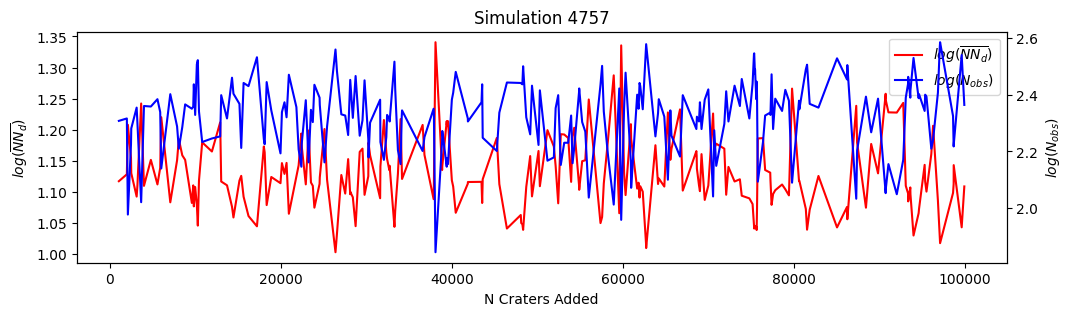

slope                          2.746536
effective_radius_multiplier    1.130126
r_stat_multiplier              3.532516
min_rim_percentage             0.368920
Name: 2529, dtype: float64


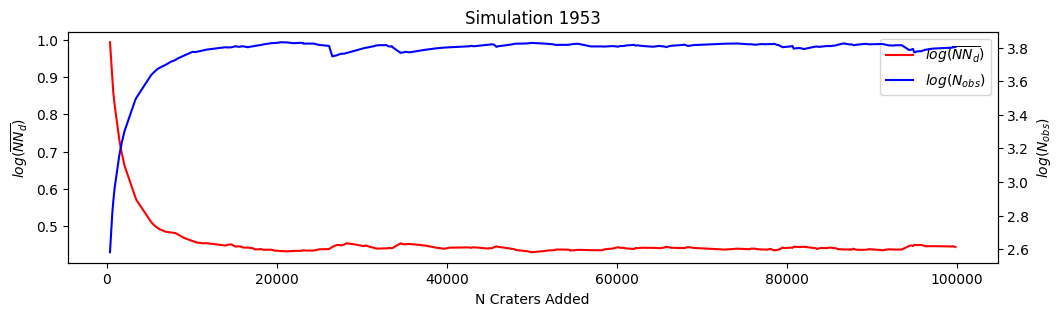

slope                          1.478376
effective_radius_multiplier    1.740153
r_stat_multiplier              7.784796
min_rim_percentage             0.472778
Name: 1495814, dtype: float64


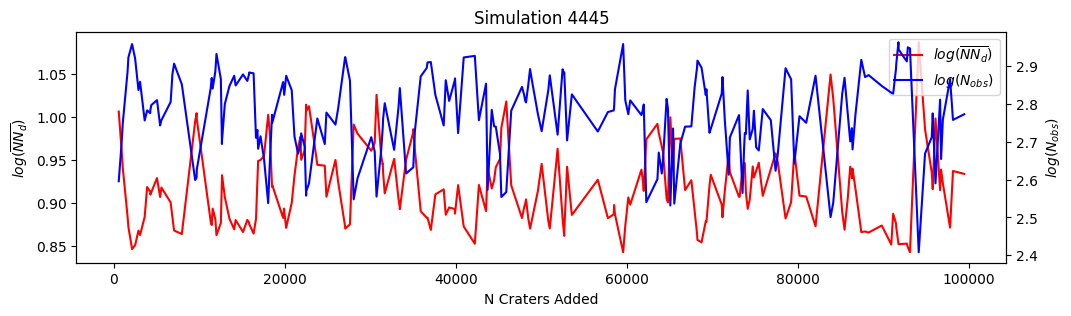

slope                          2.759432
effective_radius_multiplier    1.700635
r_stat_multiplier              5.869548
min_rim_percentage             0.477400
Name: 985859, dtype: float64


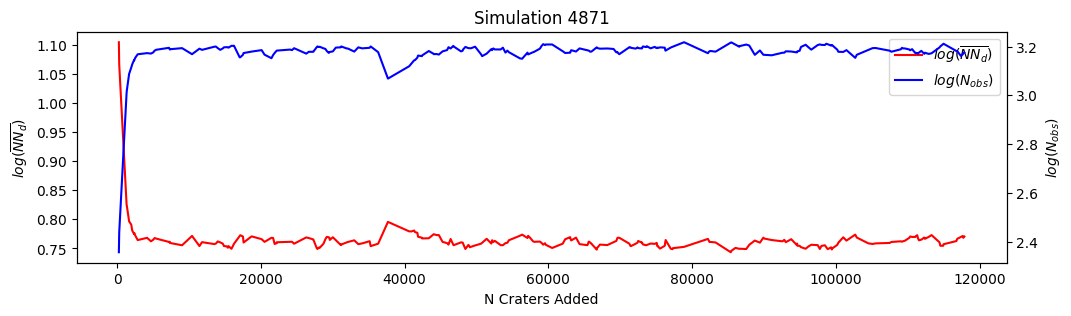

slope                          1.790503
effective_radius_multiplier    1.623375
r_stat_multiplier              7.981395
min_rim_percentage             0.501695
Name: 1195528, dtype: float64


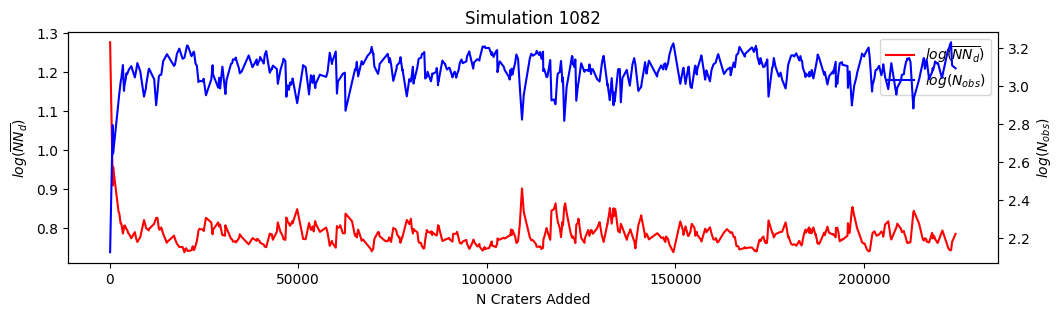

slope                          2.025588
effective_radius_multiplier    1.836425
r_stat_multiplier              8.356927
min_rim_percentage             0.669767
Name: 1868912, dtype: float64


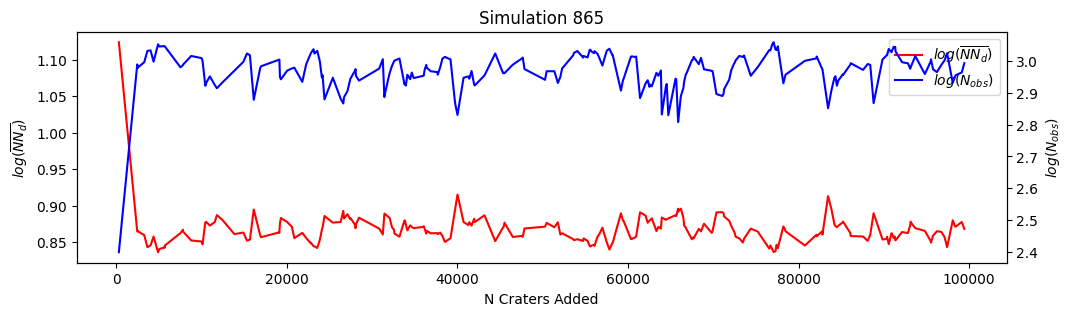

slope                          2.259392
effective_radius_multiplier    1.691005
r_stat_multiplier              6.782495
min_rim_percentage             0.475633
Name: 1106260, dtype: float64


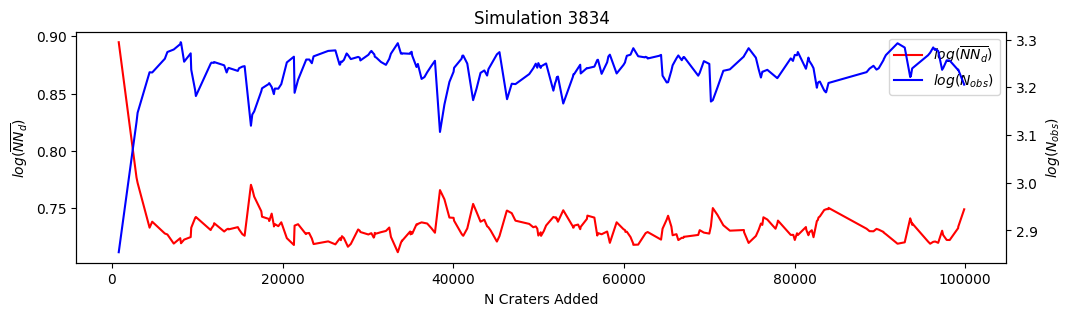

slope                          2.688464
effective_radius_multiplier    1.798523
r_stat_multiplier              3.645352
min_rim_percentage             0.372265
Name: 554840, dtype: float64


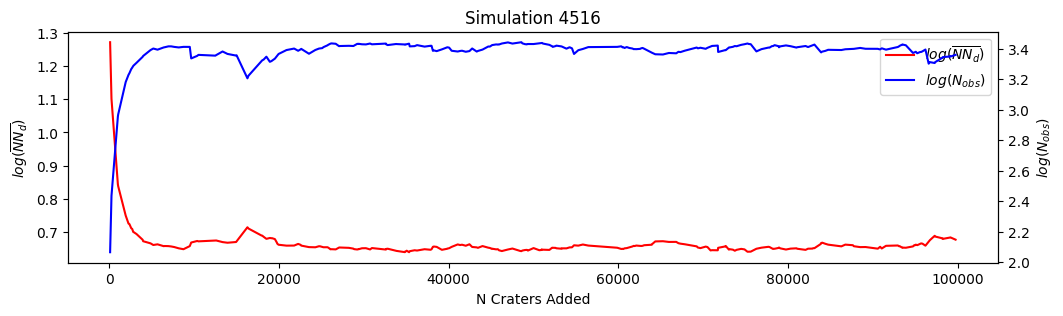

slope                          1.943943
effective_radius_multiplier    1.805293
r_stat_multiplier              8.228768
min_rim_percentage             0.601652
Name: 1601636, dtype: float64


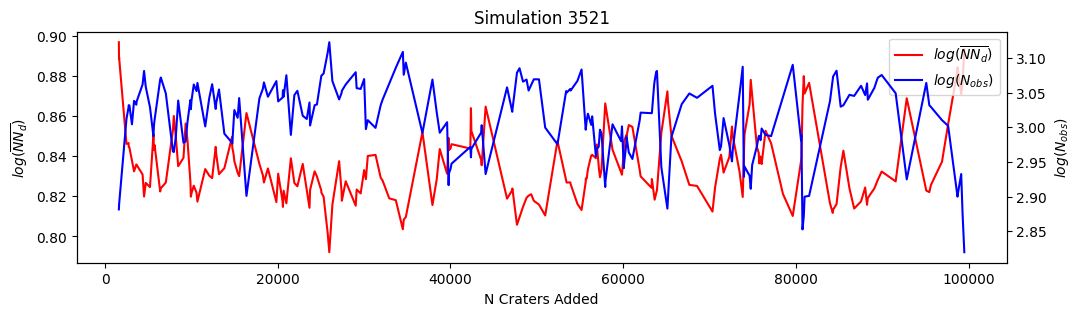

slope                          2.485853
effective_radius_multiplier    1.155122
r_stat_multiplier              4.359550
min_rim_percentage             0.557177
Name: 166288, dtype: float64


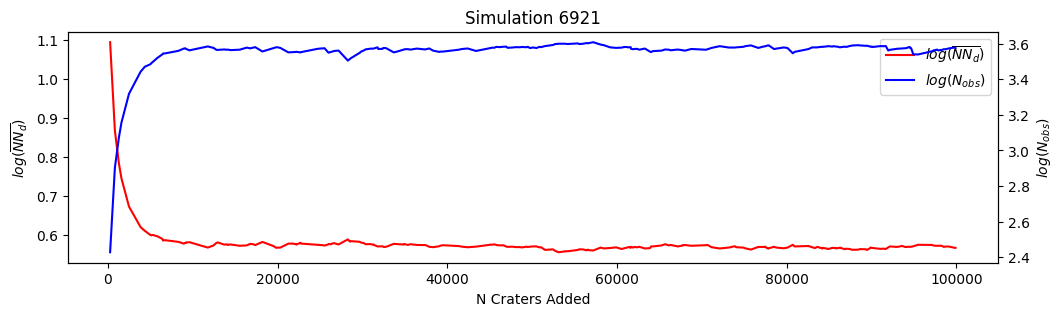

slope                          2.094033
effective_radius_multiplier    1.525037
r_stat_multiplier              7.436235
min_rim_percentage             0.427477
Name: 564261, dtype: float64


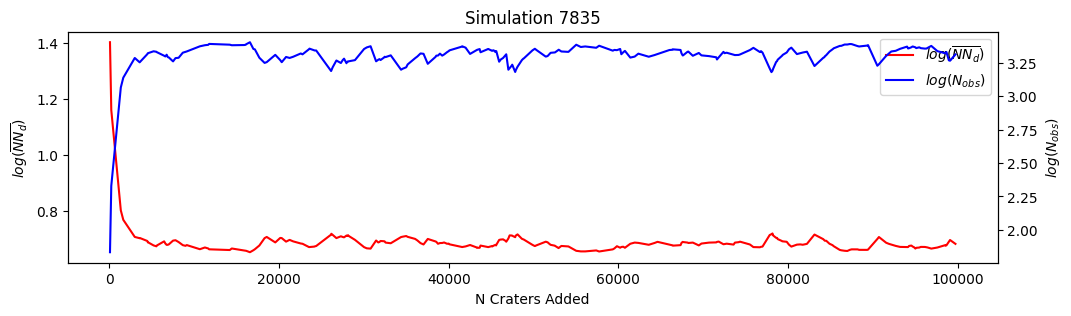

slope                          2.371307
effective_radius_multiplier    1.228468
r_stat_multiplier              3.805790
min_rim_percentage             0.548129
Name: 152712, dtype: float64


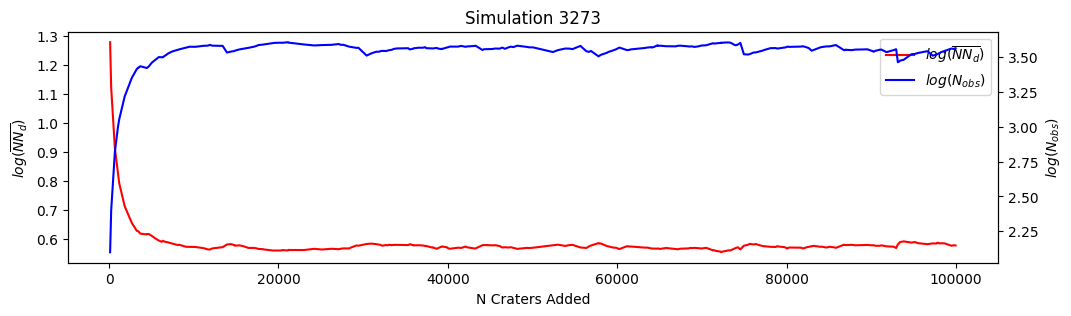

slope                          1.490824
effective_radius_multiplier    1.882129
r_stat_multiplier              5.431265
min_rim_percentage             0.308104
Name: 1278781, dtype: float64


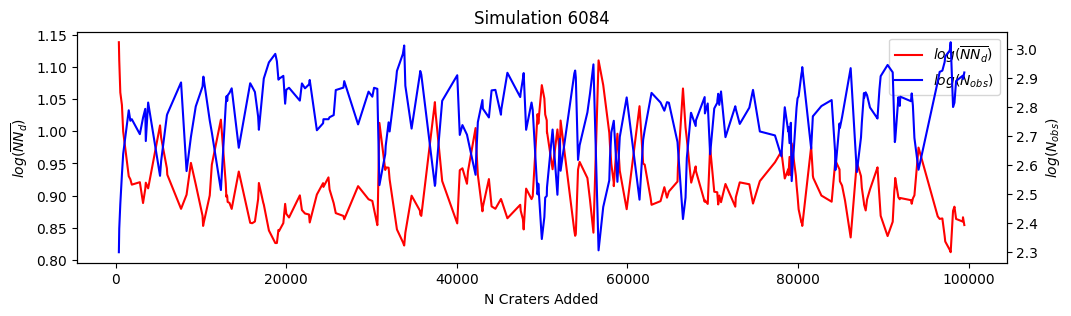

slope                          2.493521
effective_radius_multiplier    1.264706
r_stat_multiplier              7.613312
min_rim_percentage             0.337335
Name: 88102, dtype: float64


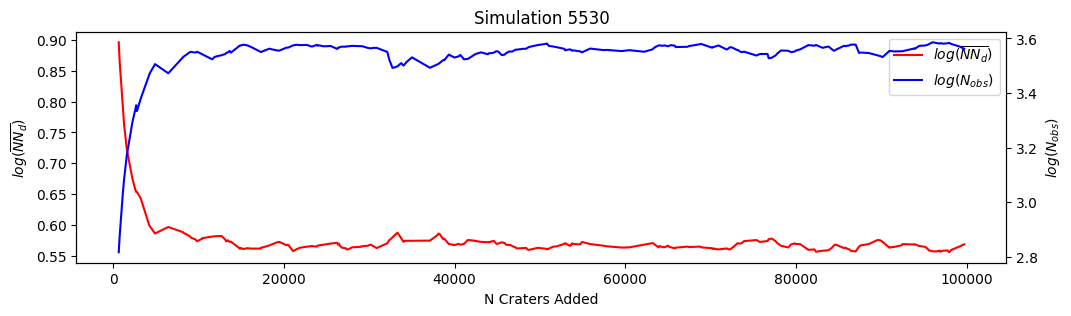

slope                          2.213060
effective_radius_multiplier    1.449061
r_stat_multiplier              5.023719
min_rim_percentage             0.663887
Name: 1292044, dtype: float64


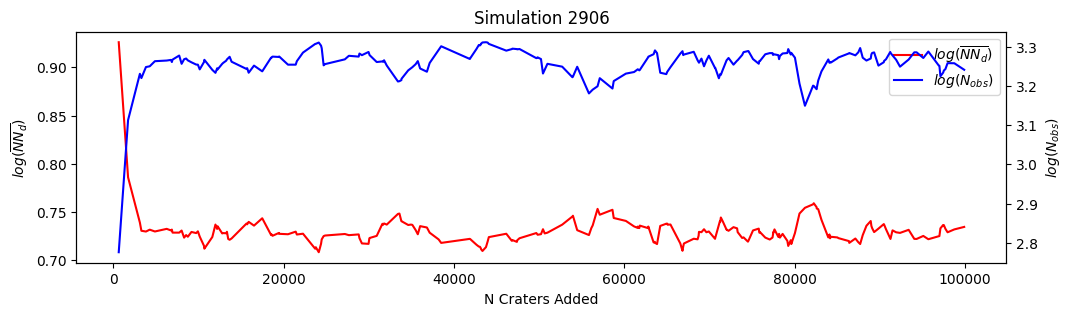

slope                          1.139557
effective_radius_multiplier    1.760416
r_stat_multiplier              4.031447
min_rim_percentage             0.394985
Name: 1475075, dtype: float64


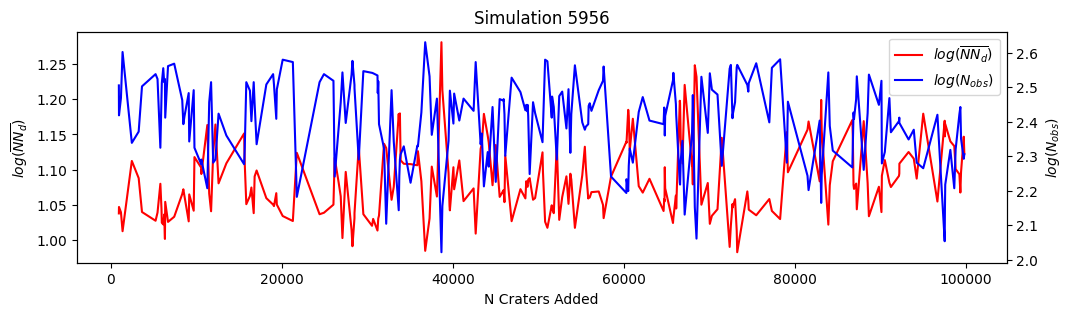

slope                          1.143986
effective_radius_multiplier    1.816862
r_stat_multiplier              4.367290
min_rim_percentage             0.578332
Name: 1683157, dtype: float64


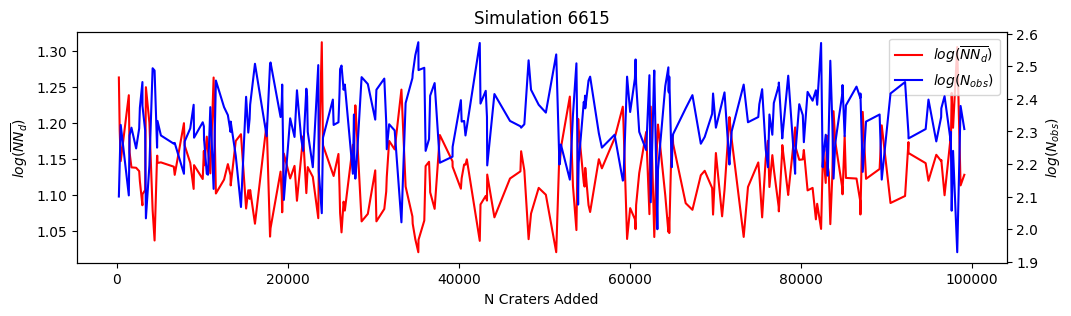

slope                          2.323248
effective_radius_multiplier    1.707086
r_stat_multiplier              8.628503
min_rim_percentage             0.402594
Name: 758969, dtype: float64


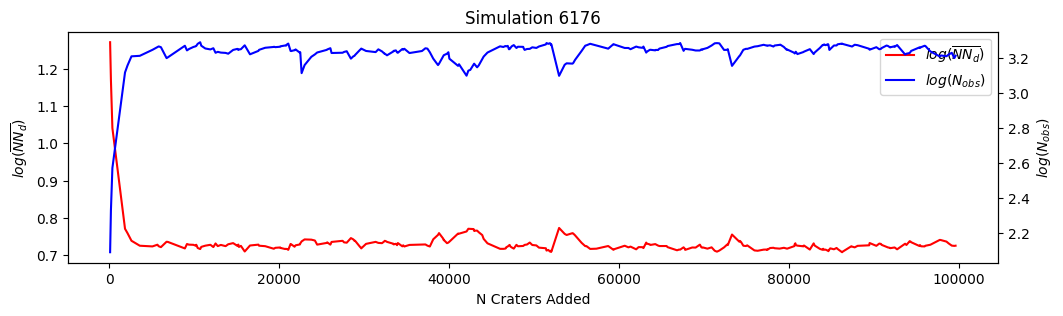

slope                          2.606935
effective_radius_multiplier    1.211274
r_stat_multiplier              6.505573
min_rim_percentage             0.430977
Name: 144051, dtype: float64


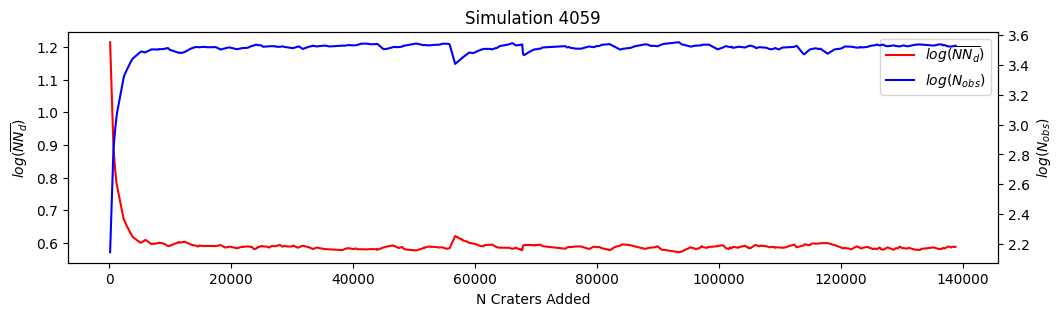

slope                          1.648563
effective_radius_multiplier    1.593358
r_stat_multiplier              6.350903
min_rim_percentage             0.312511
Name: 682985, dtype: float64


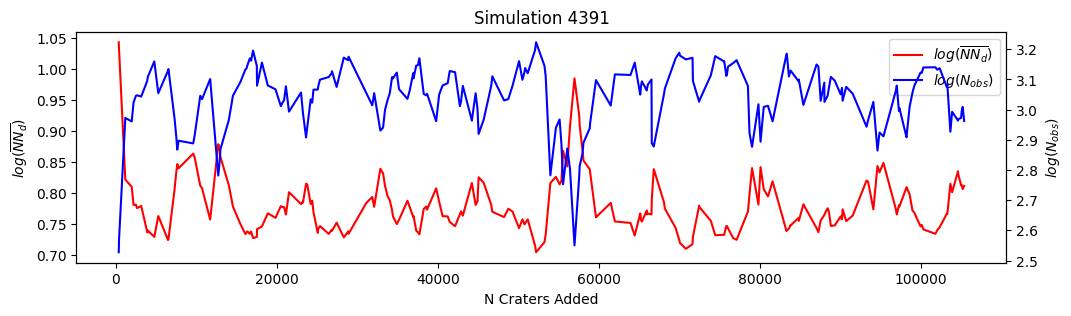

In [7]:
for sim_id in np.random.choice(df.simulation_id.drop_duplicates(), 20):
    plot_log_N_and_log_NNd_for_simulation(sim_id, df)

In [58]:
# Randomly arrange the points
# Ordering affects which points in the subsequent plots are "on top" of others
df["rnd"] = np.random.rand(df.shape[0])
df = df.sort_values("rnd")

In [59]:
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="slope",
    hover_data=["simulation_id", "slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [60]:
# Trying a range selector
to_show = df.copy()
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])
to_show["log_n_craters_in_study_region"] = np.log10(to_show.n_craters_in_study_region)
to_show["log_areal_density_overlap_2"] = np.log10(to_show.areal_density_overlap_2)

range_x = [to_show.log_mean_c2c_nn_dist.min(), to_show.log_mean_c2c_nn_dist.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="log_ad",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



## Plotting single simulations

In [41]:
df = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(25))
    & (data.simulation_id == 4935)
).cache()

n_pts = 10000
n_obs = df.count()

if n_obs > n_pts:
    sample_fraction = n_pts / n_obs
    df = df.sample(sample_fraction)

pandas_df = df.toPandas()
pandas_df["log_n_craters_in_study_region"] = np.log10(pandas_df.n_craters_in_study_region)
pandas_df = pandas_df.sort_values("log_n_craters_in_study_region")

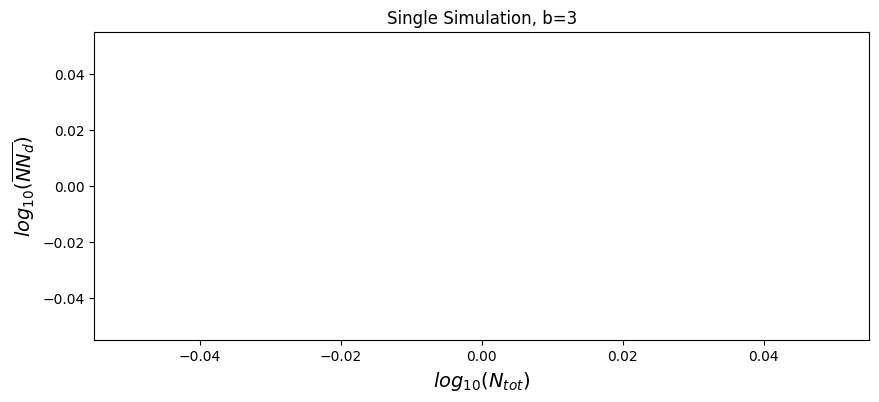

In [42]:
plt.figure(figsize=(10, 4))
plt.plot(
    # np.log10(pandas_df.n_craters_added_in_study_region),
    np.log10(pandas_df.log_n_craters_in_study_region),
    pandas_df.log_mean_c2c_nn_dist,    
)
plt.title("Single Simulation, b=3")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(\overline{NN_d})$", size=14)
plt.show()

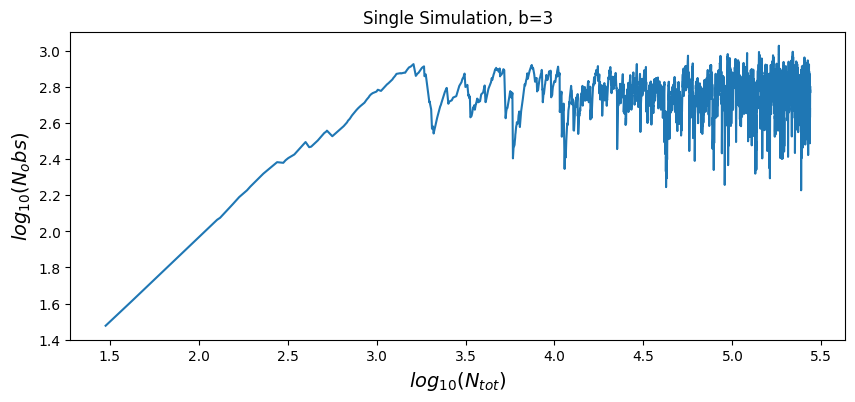

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(
    np.log10(pandas_df.n_craters_added_in_study_region),
    np.log10(pandas_df.n_craters_in_study_region),
)
plt.title("Single Simulation, b=3")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(N_obs)$", size=14)
plt.show()